In [3]:
import re
from os import path
import numpy as np
import pandas as pd
import zipfile
import nltk
# import wget
import time
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import SimpleRNN,Dense,LSTM,Dropout,GRU,Bidirectional
from keras import regularizers


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [5]:
# Only include classes specified in accepted_class 
def clean_class(df,accepted_class:np.ndarray):
   # accepted_class = np.array([1, 0, -1])
    decode_map = {0: 0, 2: 2, 1: 1,-1:-1, '0': 0, '2': 2, '1': 1,'-1':-1}
    df['target'].map(decode_map)
    df = df.loc[df['target'].isin(accepted_class)]
    df.astype({'target': 'int'}).dtypes
    return df

In [6]:
def preprocess_text(text):
    text = text.lower()
    # removing tags and text inside tags Eg: <a> , <e>
    text = re.sub('<[^>]*>','',text)
    # removing Http Links
    text = re.sub('https?:\S+','',text)
    # removing special characters
    text = re.sub('[^\w\s]','',text)
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) 
    return text.strip()

In [7]:
%%time
def load_glove_embeddings():
    if not path.exists('glove.twitter.27B.zip'):
        print('Please wait while the Global Vector Word Embeddings are being downloaded.')
        !wget 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
        #unzip glove*.zip
    glove = zipfile.ZipFile('glove.twitter.27B.zip')
    embeddings = {}
    with glove.open('glove.twitter.27B.200d.txt') as file:
        for line in file:
            line = line.decode('utf-8')
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            embeddings[word] = word_vectors
    return embeddings
word_embeddings = load_glove_embeddings()

CPU times: user 2min 16s, sys: 3.66 s, total: 2min 20s
Wall time: 2min 20s


In [8]:
def generate_embeddings():
    vocab_size = len(tokenizer.word_index)+1
    embedding_size = 200
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    for word,index in tokenizer.word_index.items():
        vector = word_embeddings.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
    return embedding_matrix

In [9]:
# def read_input():
#     if not path.exists('training-Obama-Romney-tweets.rar'):
#         print('Downloading training-Obama-Romney-tweets.rar')
#         wget.download('https://www.cs.uic.edu/~liub/teach/cs583-fall-20/training-Obama-Romney-tweets.rar')
#     rar = rarfile.RarFile('training-Obama-Romney-tweets.rar')
#     input =rar.open('training-Obama-Romney-tweets.xlsx')
#     return input

In [10]:
sheets = [0,1]
input_data = pd.read_excel('training-Obama-Romney-tweets.xlsx',sheet_name=sheets)

In [11]:
def clean_excel(data:pd.DataFrame):
    # Preprocessing Training data
    # Removing first row as it has only information about class value mappings
    data = data[1:]
    data.rename(columns={'Unnamed: 4': 'target'}, inplace=True)
    # Dropping empty columns
    data.dropna(how='all', inplace=True, axis=1)
    #Dropping date and time
    data.dropna(subset=['Anootated tweet','target'] ,inplace=True, axis=0)
    return data

In [12]:
data_clean = pd.DataFrame()
for i in sheets:
    data_temp = clean_excel(input_data[i])
    data_clean=data_clean.append(data_temp)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/pandas/core/fra

In [13]:
data_clean = clean_class(data_clean,np.array([1,0,-1]))

In [14]:
%%time
data_clean['Anootated tweet']=data_clean['Anootated tweet'].apply(lambda x: preprocess_text(x))

CPU times: user 30 s, sys: 2.36 s, total: 32.3 s
Wall time: 32.3 s


In [15]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11118 entries, 1 to 7200
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             11114 non-null  object
 1   time             11111 non-null  object
 2   Anootated tweet  11118 non-null  object
 3   target           11118 non-null  object
dtypes: object(4)
memory usage: 434.3+ KB


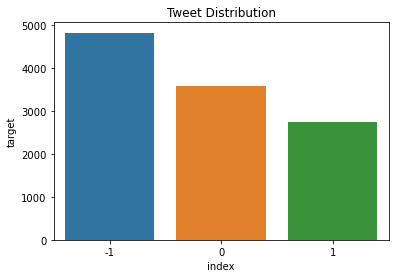

In [16]:
target_count = data_clean['target'].value_counts().reset_index()
ax = sns.barplot(x=target_count['index'], y=target_count['target'])
plt.title("Tweet Distribution")
plt.show()


In [17]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_clean['Anootated tweet'],data_clean['target'], test_size=0.2, stratify=data_clean['target'])

In [18]:
tokenizer = Tokenizer(num_words=20000,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [19]:
word_embedding_matrix = generate_embeddings()

In [20]:
word_embedding_matrix.shape

(14860, 200)

In [44]:
X_train_processed = tokenizer.texts_to_sequences(X_train)
X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')

In [79]:
model = Sequential()
embedding_layer = Embedding(len(tokenizer.word_index)+1, 200, weights=[word_embedding_matrix], input_length=50,trainable = False,mask_zero=True)
model.add(embedding_layer)

In [80]:
model.add(LSTM(100,kernel_regularizer =regularizers.l1_l2(l1=0.01, l2=0.01)))

In [81]:
model.add(Dropout(0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 200)           2972000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 3,102,803
Trainable params: 130,803
Non-trainable params: 2,972,000
_________________________________________________________________
None


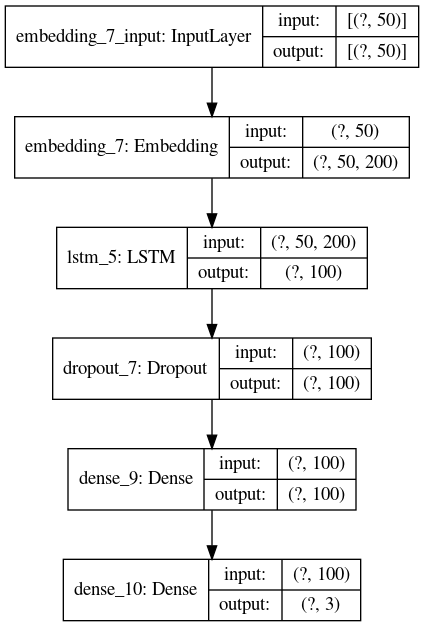

In [82]:
import pydot
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [83]:
model_history = model.fit(X_train_processed, pd.get_dummies(y_train).values, batch_size=128, epochs=20, verbose=1,validation_split = 0.2)

Epoch 1/20


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:388 update_state
        self.build(y_pred, y_true)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:319 build
        self._metrics, y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1139 map_structure_up_to
        **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1235 map_structure_with_tuple_paths_up_to
        *flat_value_lists)]
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1234 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1137 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:419 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:419 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:438 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:3483 get
        return deserialize(str(identifier))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:3443 deserialize
        printable_module_name='metric function')
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:378 deserialize_keras_object
        'Unknown ' + printable_module_name + ': ' + object_name)

    ValueError: Unknown metric function: f1


In [58]:
model.predict_classes(X_train_processed)

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
X_train_processed

array([[ 305,  165,   46, ...,    0,    0,    0],
       [   2,  236, 5692, ...,    0,    0,    0],
       [  52,  352,    2, ...,    0,    0,    0],
       ...,
       [1367,  547, 1187, ...,    0,    0,    0],
       [   4,    3,  134, ...,    0,    0,    0],
       [3619, 3620, 2407, ...,    0,    0,    0]], dtype=int32)

In [59]:
pd.get_dummies(y_train).values

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)